## In this example we study influence of difference confounds on qPCR expression profile

We provide an example data with Ct values provided with RT-qPCR.

In [1]:
import pandas as pd

In [2]:
expression_with_metadata = pd.read_csv('expression_data.csv',  sep='\t')
expression_with_metadata.head()

,organoid_id,batch,clone,donor,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8
0,Organoid001,Batch16,Clone32,Donor13,21.88529,30.74224,18.49736,15.25977,29.54574,27.03209,16.98858,32.25044
1,Organoid002,Batch16,Clone34,Donor13,21.89152,28.50605,19.11512,15.08179,28.59296,25.96716,16.41167,26.74259
2,Organoid003,Batch16,Clone35,Donor13,21.87853,30.15407,18.08858,15.07104,28.84508,26.74122,17.51716,31.73743
3,Organoid004,Batch16,Clone38,Donor14,21.68321,31.27373,19.55177,14.74305,29.19585,26.72670,18.00265,33.79955
4,Organoid005,Batch16,Clone36,Donor13,23.60080,30.36293,18.67999,17.94527,31.74991,30.38791,17.53866,32.85957


## Computing similarity

Goal is to sort all samples by similarity in expression profile. <br />
Each row in resulting matrix is ids of other samples ordered by similarity
<!-- We first  -->

In [3]:
genes_expression = expression_with_metadata[['Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5', 'Gene6', 'Gene7', 'Gene8']].copy()
# compute delta Ct
genes_delta_ct = genes_expression.sub(genes_expression['Gene1'], axis=0).drop(columns='Gene1')
# normalize contribution of each gene
genes_delta_ct_normalized = genes_delta_ct.div(genes_delta_ct.std())

In [6]:
genes_delta_ct_normalized.head()

,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8
0,4.309973,-0.692483,-16.124176,3.979017,1.374233,-2.198765,2.377550
1,3.218765,-0.567488,-16.572478,3.480885,1.088226,-2.460612,1.112735
2,4.027047,-0.774655,-16.567026,3.618589,1.298374,-1.958382,2.261427
3,4.666943,-0.435660,-16.889898,3.902241,1.346649,-1.652678,2.779236
4,3.290591,-1.005799,-13.763563,4.232838,1.812208,-2.722077,2.123769


## Compute RTG scores

In [12]:
from rtg_score import compute_contibution_matrix, compute_r2g_score

In [14]:
contribution_matrix = compute_contibution_matrix(
    expression_with_metadata,
    include_same_dict = {
        'batch':            ['batch'],
        'donor':            ['donor'],
        'clone':            ['clone'],
        'batch+\ndonor':    ['batch', 'donor'],
        'batch+\nclone':    ['batch', 'clone'],
    },
    exclude_same_dict={
        'exclude same\norganoid': ['organoid_id'],
        'exclude same\nclone':    ['clone'],
        'exclude same\ndonor':    ['donor'],
        'exclude same\nbatch':    ['batch'],
    },
    embeddings=genes_delta_ct_normalized,
)

In [15]:
contribution_matrix

,batch,donor,clone,batch+\ndonor,batch+\nclone
exclude same\norganoid,0.599594,0.662743,0.723485,0.812123,0.93722
exclude same\nclone,0.581381,0.602667,NaN,0.693030,NaN
exclude same\ndonor,0.571747,NaN,NaN,NaN,NaN
exclude same\nbatch,NaN,0.623786,0.660662,NaN,NaN


## Plotting

(you may need to install seaborn and matplotlib - plotting packages, not required by rtg_score)

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

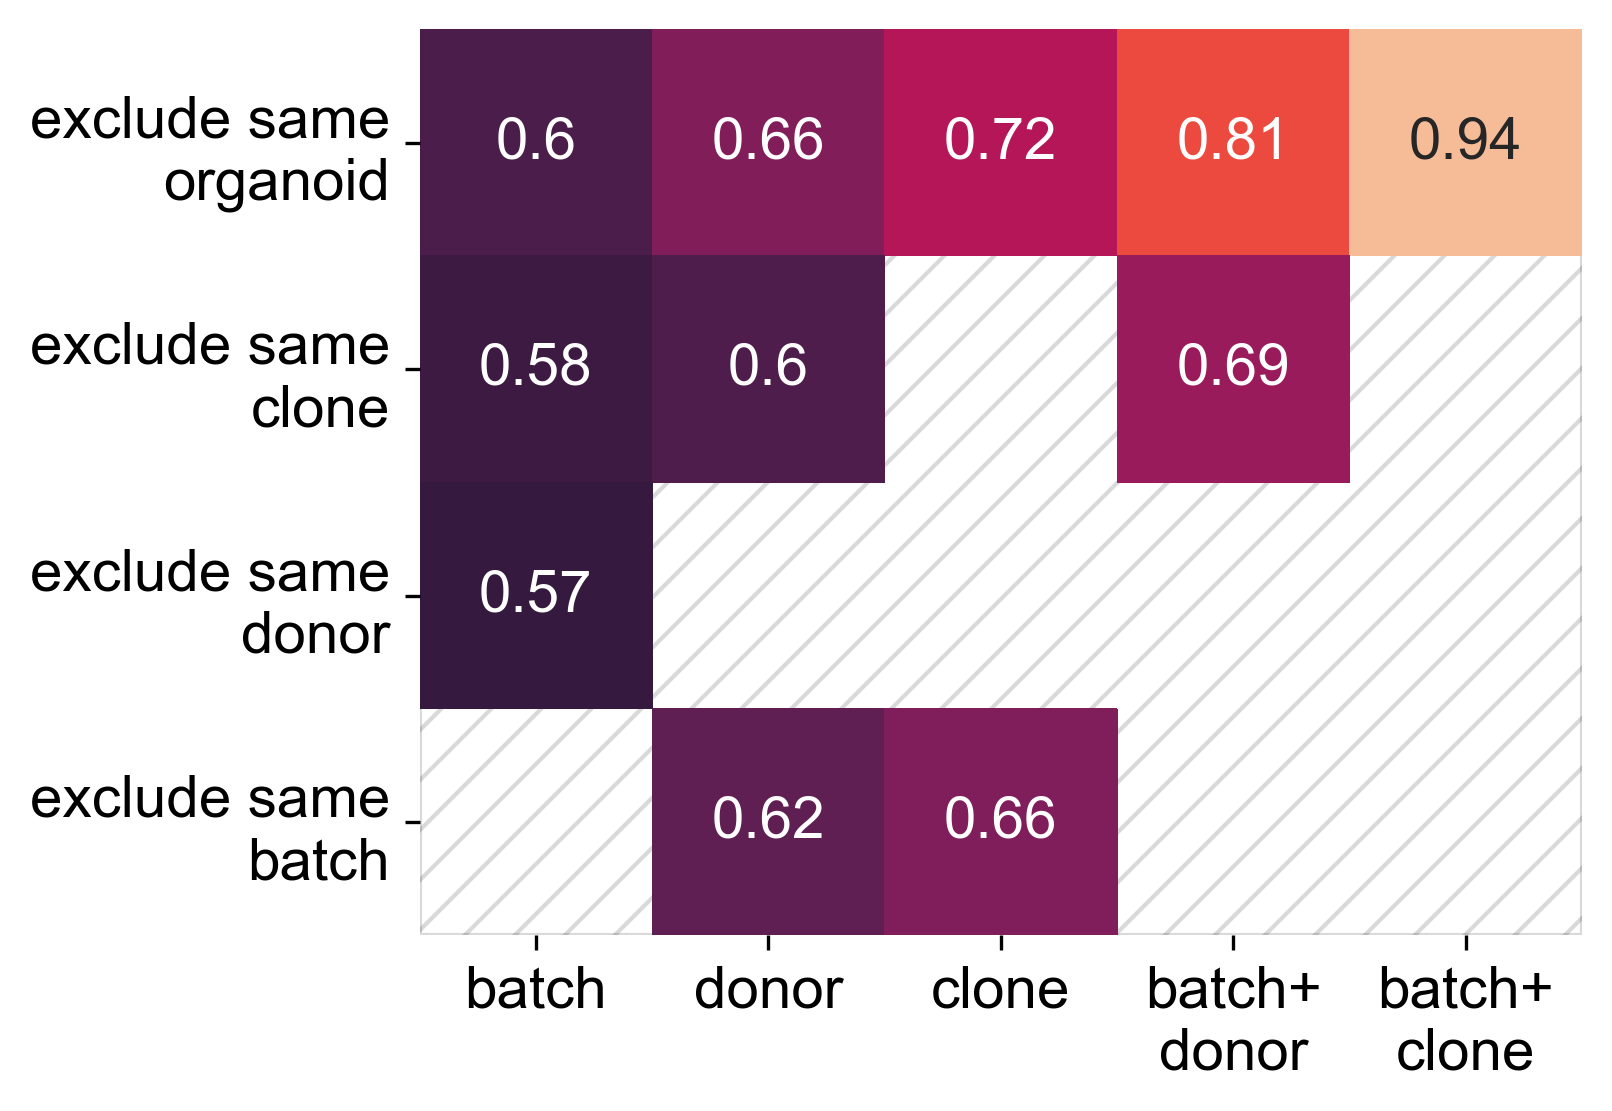

In [17]:
with plt.rc_context({
    'font.family': 'sans-serif', 
    'font.sans-serif': 'Arial', 
    'font.size': 18, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14, 
}):

    _fig, ax = plt.subplots(figsize=[5, 4], dpi=300)
    # background hatching to show missing values
    ax.add_patch(plt.Rectangle((0., 0.), contribution_matrix.shape[1], contribution_matrix.shape[0], 
                               fill=False, edgecolor='k', alpha=0.15, hatch='//', zorder=-42))
    sns.heatmap(
        contribution_matrix,
        vmax=1.0,
        vmin=0.5,
        annot=True,
        annot_kws={"size": 14},
        cbar=False,
        ax=ax,
    )
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.savefig('confounder_contribution.svg', bbox_inches="tight")
    plt.savefig('confounder_contribution.png', bbox_inches="tight")
    plt.show()